# Pollution



Pour travailler sur les polluants, nous sommes partis sur les Données « temps réel » de mesure des concentrations de polluants atmosphériques réglementés du Laboratoire Central de Surveillance de la Qualité de l'Air (LCSQA) archivée sur [data.gouv.fr](https://www.data.gouv.fr/datasets/donnees-temps-reel-de-mesure-des-concentrations-de-polluants-atmospheriques-reglementes-1/informations) sous l'identifiant **5b98b648634f415309d52a50**. 

Les données de mesure de 2021 à 2025 sont archivées suivant un format CSV horaire.
Pour les données horaires de 2019 à 2021, elles sont archivées suivant un format XML.
Nous allons donc construire une aggrégation suivant l'indice réducteur ATMO par trimestre.
Dans la suite après la construction des données géographiques et de l'indice ATMO, nous aborderons la récupération dans un premier temps des données CSV puis de celles XML.


In [ ]:
!pip install lxml

In [ ]:
import json
import pandas as pd
import re
import os
import pathlib
import xml.etree.ElementTree as ET
import plotly.express as px
import unicodedata 

## Prerequis
Récupération des données en locale pour travailler.

Pour les données brutes, il faut télécharger le fichier :
https://oasis-prd-001.s3.us-east-1.amazonaws.com/raw/airquality/pollution-2021-2025-CSV.zip
et le décompresser dans le repertoire local _data_ à la racine du projet.

### Positionnement du repertoire de travail du départ du notebook

Adpatation pour se placer dans le repertoire : notebooks/pollution


In [ ]:

%pwd
#os.chdir("../notebooks/pollution")
%pwd


### Construction des repertoires de travail

In [ ]:
pollution_notebook_dir=str(pathlib.Path().resolve())
print("pollution notebook directory :",pollution_notebook_dir)
os.chdir("../../data")
data_dir=str(pathlib.Path().resolve())
data_pollution_dir=data_dir+"/pollution"
print("data directory :",data_dir)
print("pollution data directory :",data_pollution_dir)
os.chdir("..")
repo_dir=str(pathlib.Path().resolve())
print("Oasis repository root directory :",repo_dir)
os.chdir("./notebooks/pollution")
print("Here we are :",pathlib.Path().resolve())

## Acces au Bucket S3 Oasis
Il s'agit de l'ajout du code d'accès au bucket S3 :
https://oasis-prd-001.s3.us-east-1.amazonaws.com/data

In [ ]:
import os

import boto3
import pandas as pd
from dotenv import load_dotenv


In [ ]:
# Load environment variables
load_dotenv()

AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")


In [ ]:
def load_file_s3(object_key: str)->pd.DataFrame:
    """Load a file from S3 and print its contents."""
    if not AWS_S3_BUCKET or not AWS_ACCESS_KEY_ID or not AWS_SECRET_ACCESS_KEY:
        raise ValueError("AWS credentials or bucket name not set in environment variables.")

    s3_client = boto3.client(
        "s3",
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    )

    response = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=object_key)

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    if status == 200:
        print(f"Successful S3 get_object response. Status - {status}")
        return pd.read_csv(response.get("Body"))
    raise ValueError(f"Unsuccessful S3 get_object response. Status - {status}")


In [ ]:
os.chdir(pollution_notebook_dir)

## Qu'est-ce qu'une Zone Administrative de Surveillance ?

Afin de répondre aux exigences européennes, la France est découpée en zones administratives de surveillance (ZAS). Ce zonage est indispensable pour les besoins de rapportage des données de mesure des polluants réglementés, auprès de la Commission européenne. Ces zones sont délimitées en tenant compte des niveaux de polluants et donc des risques de dépassements réglementaires, ainsi que des populations résidentes.

Depuis 2022, un nouveau zonage est mis en place pour 5 ans. Les zones administratives de surveillance sont classées en trois catégories ([lire l'Arrêté du 9 mars 2022](https://www.lcsqa.org/system/files/media/documents/JO-Arrete%2009%20mars%202022-découpage_regions-ZAS_0.pdf)) :

- « **zone à risques - agglomération** » (ZAG) qui comporte une agglomération de plus de 250 000 habitants, telle que définie par l’arrêté prévu à l’article L. 222-4 du code de l’environnement, ou ayant une densité d’habitants au kilomètre carré supérieure à un seuil établi par le ministère chargé de l’environnement
- « **zone à risques – hors agglomération** » (ZAR) qui ne répond pas aux critères des ZAG et dans lesquelles les normes de qualité de l’air mentionnées à l’article R. 221-1 du code de l’environnement ne sont pas respectées ou risquent de ne pas l’être
- « **zone régionale** » (ZR) qui s’étend sur le reste du territoire de la région
Les AASQA assurent la surveillance et l’évaluation de la qualité de l’air pour les polluants réglementés dans chaque Zone Administrative de Surveillance.

Plus d'information [ici](https://www.lcsqa.org/fr/les-zones-administratives-et-stations-de-surveillance) 

Le dispositif national de surveillance s’appuie sur des appareils de mesure conformes répartis sur près de 650 stations de mesures ainsi que sur des outils de modélisation.



### travail sur la localisation des stations et ZAS

 A partir de [l'arrêté du 9 mars 2022](), il a été possible d'extraire de l'annexe l'association entre les ZAS et les communes asociées.Cette association est placée dans le fichier JSON _zas_communes.json_ déposé dans le repertoire data et sur le bucket S3.

In [ ]:
df_zar_ville=pd.read_csv(data_pollution_dir+"/zar_communes_groupes.csv")
df_zas_final=pd.read_csv(data_pollution_dir+"/communes_final_zr_zar_propre.csv")
commune_zar_villes=df_zar_ville[["zas","nom_commune_complet"]]
communes_zas_zr=df_zas_final[["zas","nom_commune_complet"]]
communes_zas=pd.concat([communes_zas_zr,commune_zar_villes])
dico=communes_zas.to_dict(orient="dict") #str {‘dict’, ‘list’, ‘series’, ‘split’, ‘tight’, ‘records’, ‘index’}
df1 = communes_zas.groupby('zas')['nom_commune_complet'].apply(list).reset_index(name='new')
df1=df1.set_index('zas')

dico_zas=df1.to_dict(orient="dict")['new']
#dico_zas['ZAR MOULINS']

Lecture d'un fichier csv pour obtenir la liste des ZAS

In [ ]:
zas_reverse=data_pollution_dir+"/pollution-2020-2025-CSV/2025/"+"FR_E2_2025-01-01.csv"
df=pd.read_csv(zas_reverse,delimiter=";")
df.info()
kept_columns=["code site","Zas","nom site","type d'implantation"]
df_zas=df[kept_columns].drop_duplicates()
df_zas.set_index("code site",inplace=True)
df_zas.info()
df_zas.at['FR01018','Zas']
dicozas=df_zas.to_dict(orient='dict')['Zas']

df_zas['Zas'].unique()

In [ ]:
zas=dico_zas
def Zas_Commune_INSEE_List(zas_str:str)->list:
    try:
        zas[zas_str]
    except: 
        print(" ZAS inconnue : ",zas_str)
        return ["UNKNOWN ZAS",]
    return zas[zas_str]

In [ ]:
# test de la focntion d'association des communes au code INSEE
#display(zas)
display(Zas_Commune_INSEE_List('ZAR REIMS'))
display(Zas_Commune_INSEE_List('ZAR CHARTRES-DREUX'))
display(Zas_Commune_INSEE_List('ZR AUVERGNE-RHONE-ALPES'))
display(Zas_Commune_INSEE_List('ZAR MOULINS'))


Nous récupérons notre référentiel INSEE des communes de France métropolitaine. Cela va nous permettre de construire un "mapping" entre les communes et leur ZAS associée.

In [ ]:

def enlever_accents_majuscules(texte:str)->str:
    texte_modifie = ''
    for c in texte:
        # Si le caractère est une majuscule accentuée
        if c.isupper():
            # Normalisation et retrait des diacritiques uniquement pour les majuscules
            c_sans_accent = unicodedata.normalize('NFD', c)
            c_sans_accent = ''.join(ch for ch in c_sans_accent if unicodedata.category(ch) != 'Mn')
            texte_modifie += c_sans_accent
        else:
            texte_modifie += c  # laisse tel quel
    return texte_modifie

# test de la fonction de retrait d'accent sur les majuscules 
print(enlever_accents_majuscules("Éragny à toute")," doit devenir Eragny à toute")

In [ ]:
df_insee=pd.read_csv(data_dir+"/ref_espace_communes.csv")
df_insee.info()
display(df_insee.describe(include='all'))
df_insee.head()

df_insee["nom_commune_SANS_ACCENT"]= df_insee["nom_commune_complet"].apply(enlever_accents_majuscules)

In [ ]:
topzas={}
for key,val in zas.items():
    print(f"zas : {key}")
    for commune in val:
        #indices = df_insee.where(df_insee['nom_commune_complet']==commune)
        index = df_insee.isin([commune]).any(axis=1).idxmax()
        region=df_insee.loc[index,"code_region"]
        dico={"commune": commune, "zas": key, "code_region": region}
        topzas[df_insee.loc[index,"code_commune_INSEE"]]=dico
        print(topzas[df_insee.loc[index,"code_commune_INSEE"]])
        #insee=df_insee[df_insee['nom_commune_complet']==commune].iloc[0,0]
        #print(f"commune : {commune} code INSEE: {insee}")

In [ ]:
df_zas=pd.DataFrame(topzas).T
df_zas.index.rename("INSEECOM",inplace=True)
#display(df_zas.describe())
df_zas.to_csv(data_pollution_dir+"/INSEE_COM_ZAS.csv")

## Les données sur les polluants

Les données disponibles par ces processus permettent de documenter les concentrations des
polluants atmosphériques suivants :
- Ozone (O3)
- Dioxyde d’azote (NO2)
- Dioxyde de soufre (SO2)
- Particules de diamètre inférieur à 10 micron (PM10)
- Particules de diamètre inférieur à 2,5 micron (PM2.5)
- Monoxyde de carbone (CO)
L’ensemble des observations mesurées pour les polluants ci-dessus qui participent au
dispositif de surveillance réglementaire sont mises à disposition. Les stations dont elles sont
issues ne disposent pas toutes de mesures pour l’ensemble de ces polluants, certaines ne
mesurent qu’un seul polluant de la liste, d’autres en mesurent plus.



In [ ]:
# La liste des polluants de l’Air Quality Directive (AQD) est disponible dans la vocabulaire aq/pollutant
#  du Data Dictionary Eionet. 
# Chaque polluant est référencé par une URI du type :
#               http://dd.eionet.europa.eu/vocabulary/aq/pollutant/<numéro>
# la table des polluants a été constituée à partir du scraping du site dd.eionet.europa.eu
#
df=pd.read_csv(data_pollution_dir+'/pollutants_table.csv')
polluant_dico={}
for index, row in df.iterrows():
    d=row.to_dict()
    print(d)
    polluant_dico[d['Id']]=d

print("")

print( list(df['Notation']) )
polluant_dico


### Description des polluants retenus et leur type de mesure
Pour décrire la pollution, nous nous appuyons sur l'indice ATMO car son calcul est obligatoire sur l'ensemble du territoire français.

Cinq polluants sont utilisés pour construire cet indice :
- Les particules fines < 2.5 microns (PM2.5)
- Les particules fines < 10 microns (PM10)
- L’ozone (O3)
- Le dioxyde d’azote (NO2)
- Le dioxyde de soufre (SO2) 

L’indice ATMO est un indicateur journalier qualificatif de la qualité de l’air. Il se décline en six qualificatifs définis selon différentes classes pour ces cinq polluants : « bon », « moyen », « dégradé », « mauvais », « très mauvais », « extrêmement mauvais ». 

Il intègre les polluants réglementés que l’on rencontre au quotidien : les particules en suspension (PM10 et PM2.5), le dioxyde d’azote (NO2), l’ozone (O3) et le dioxyde de soufre (SO2).

Pour plus d'information, le lecteur interessé peut se reporter au [ guide de Fédération des Associations agréées de surveillance de la qualité de l'air](https://github.com/nclsprsnw/oasis/blob/3234b05d564177b08e92d209071888ba76529ffb/docs/guide_calcul_nouvel_indice_fedeAtmo_14122020.pdf)


Le code Python suivant sert à appréhender les données des fichiers journaliers des mesures de polluant.

In [ ]:

df_pollu_test=pd.read_csv(data_pollution_dir+"/pollution-2020-2025-CSV/2025/FR_E2_2025-01-01.csv",delimiter=";")
print("Polluant")
print(df_pollu_test["Polluant"].unique())
print("ZAS")
print(df_pollu_test["Zas"].unique())
print(df_pollu_test.info())
print(df_pollu_test.head(20))
df_pollu_test["Date"]=pd.to_datetime(df_pollu_test["Date de début"], format = "%Y/%m/%d %H:%M:%S")#2021/01/01 02:00:00
df_pollu_test["Year"]=df_pollu_test["Date"].dt.year
#df_tmp0=df_pollu_test[df_pollu_test["Polluant"]=="PM2.5"][["code site","valeur"]].groupby("code site").mean()
df_tmp0=df_pollu_test[df_pollu_test["Polluant"].isin(values=("PM2.5","PM10"))][["Date","Zas","code site","Polluant","valeur"]].groupby(["Date","Zas","code site","Polluant"]).mean()
#df_tmp0[["code site","valeur"]].groupby("code site").mean()
#df_tmp=df_pollu_test[df_pollu_test["Polluant"]=="PM2.5"].groupby("code site").mean()
print(df_tmp0)
df_tmp1=df_pollu_test[df_pollu_test["Polluant"].isin(values=("NO2","SO2","O3"))][["Date","Zas","code site","Polluant","valeur"]].groupby(["Date","Zas","code site","Polluant"]).max()
print(df_tmp1)
df_tmpf=pd.concat([df_tmp0,df_tmp1]).reset_index()
print(df_tmpf.info())
print(df_tmpf.tail(20))
print(df_tmpf.index.names)
df_tmpf['valeur']=df_tmpf['valeur'].fillna(0)
#print(df_tmpf[(df_tmpf["Date"]=="01/01/2025") & (df_tmpf["code site"]=="FR01011")])
display(df_pollu_test)

### Definition de l'indice ATMO.

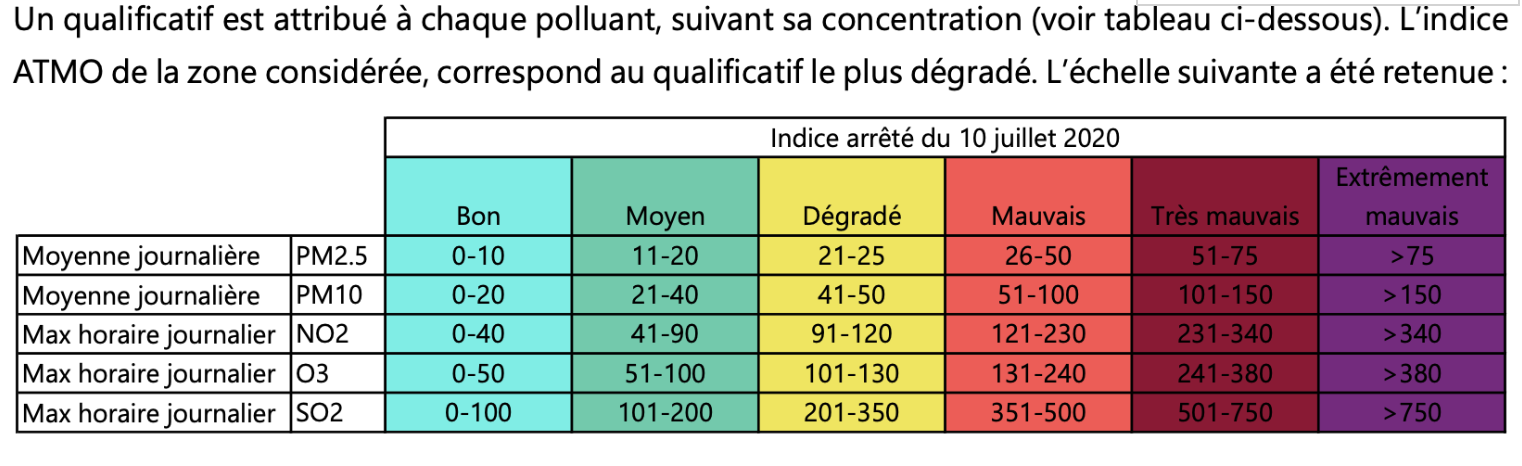

La variable ```polluants``` correspond au seuil des qualificatifs et à la méthode de mesure de ces derniers. Il s'agit de la création d'un dictionnaire synthétisant les informations du tableau ci-dessous.



In [ ]:
polluants={ "PM2.5":((10.0,20.0,25.0,50.0,75.0),
                     "Moyenne journalière"),
            "PM10":((20.0,40.0,50.0,100.0,150.0), 
                    "Moyenne journalière"),
            "NO2":((40.0,90.0,120.0,230.0,340.0),
                   "Max horaire journalier"),
            "O3":((50.0,100.0,130.0,240.0,380.0),
                  "Max horaire journalier"),
            "SO2":((100.0,200.0,350.0,500.0,750.0),
                   "Max horaire journalier")}

La fonction ci-dessous permet de traduire les valeurs des différents polluants en l'indice normalisé ATMO.

In [ ]:
def Criterion_ATMO(no2:float,so2:float,o3:float, pm25:float, pm10:float)->int:
    resu=0
    for i, val in enumerate(polluants["NO2"][0]):
        #print("i ",i," val ",val,"  no2 ",no2," resu ",resu)
        if (no2>val): 
            resu=max(resu,i)   
    for i, val in enumerate(polluants["SO2"][0]):
        if so2>val: 
            resu=max(resu,i)
    for i, val in enumerate(polluants["O3"][0]):
        if o3>val: 
            resu=max(resu,i)
    for i, val in enumerate(polluants["PM2.5"][0]):
        if pm25>val: 
            resu=max(resu,i)
    for i, val in enumerate(polluants["PM10"][0]):
        if pm10>val: 
            resu=max(resu,i)
    return int(resu)

def Polluant_H2D(df:pd.DataFrame)-> pd.DataFrame:
    # regroupper par "code site", 
    # garder pour les "Polluant": [ 'NO2', 'O3', 'PM10', 'PM2.5',  'SO2']  sur ['NO', 'NO2', 'O3', 'NOX as NO2', 'PM10', 'PM2.5', 'C6H6', 'SO2', 'CO']
    df_tmp0=df[df["Polluant"].isin(values=("PM2.5","PM10"))][["Date","Year","Month","Quarter","Zas","code site","Polluant","valeur"]].groupby(["Date","Year","Month","Quarter","Zas","code site","Polluant"]).mean()
    df_tmp1=df[df["Polluant"].isin(values=("NO2","SO2","O3"))][["Date","Year","Month","Quarter","Zas","code site","Polluant","valeur"]].groupby(["Date","Year","Month","Quarter","Zas","code site","Polluant"]).max()
    df_tmpf=pd.concat([df_tmp0,df_tmp1]).reset_index()
    return df_tmpf

def Csv_Traitement(file) -> pd.DataFrame:
    #
    # we read a daily file, transform the date 
    # and compute for the whole day Polluant according to ATMO guide.
    # Unaccessary columns are removed :
    # ["Date de début", "Date de fin","Organisme","code zas","taux de saisie","couverture temporelle","couverture de données"]
    # 
    df=pd.read_csv(file,delimiter=";")
    df["Date"]=pd.to_datetime(df["Date de début"], format = "%Y/%m/%d %H:%M:%S")
    df["Year"]=df["Date"].dt.year
    df["Month"]=df["Date"].dt.month
    df["Quarter"]=df["Date"].dt.quarter
    #display(df.info())
    df=df.drop(columns=["Date de début", "Date de fin","Organisme","code zas","taux de saisie","couverture temporelle","couverture de données"])
    df=Polluant_H2D(df)
    #df1=df[df["Polluant"].isin(values=("PM2.5","PM10"))][["Date","Zas","code site","Polluant","valeur"]].groupby(["Date","Zas","code site","Polluant"]).mean()
    #df2=df[df["Polluant"].isin(values=("NO2","SO2","O3"))][["Date","Zas","code site","Polluant","valeur"]].groupby(["Date","Zas","code site","Polluant"]).max()
    #df=pd.concat([df1,df2]).reset_index()
    df['valeur']=df['valeur'].fillna(0.0)
    return df




In [ ]:
def build_dayly_dataframe_ATMO(df_tmpf:pd.DataFrame)->pd.DataFrame:
    date=df_tmpf["Date"][0]
    year=df_tmpf["Date"].dt.year[0]
    month=df_tmpf["Date"].dt.month[0]
    quarter=df_tmpf["Date"].dt.quarter[0]
    #print(f"{year}/{month}-{quarter}")
    #print(df_tmpf["Zas"].unique())
    for zas in df_tmpf["Zas"].unique():
        stations=df_tmpf[df_tmpf["Zas"]==zas]["code site"].unique()
        #print(stations)
        for site in stations:
            df_int=df_tmpf[df_tmpf["code site"]==site]
            no2=0.0
            if (len(df_int[df_int["Polluant"]=="NO2"].valeur) >0) : 
                no2=df_int[df_int["Polluant"]=="NO2"].valeur.iloc[0]
            pm25=0.0
            if (len(df_int[df_int["Polluant"]=="PM2.5"].valeur) >0) : 
                pm25=df_int[df_int["Polluant"]=="PM2.5"].valeur.iloc[0]
            pm10=0.0
            if (len(df_int[df_int["Polluant"]=="PM10"].valeur) >0) : 
                pm10=df_int[df_int["Polluant"]=="PM10"].valeur.iloc[0]
            o3=0.0
            if (len(df_int[df_int["Polluant"]=="O3"].valeur) >0) : 
                o3=df_int[df_int["Polluant"]=="O3"].valeur.iloc[0]
            so2=0.0
            #print("len : ",len(df_int[df_int["Polluant"]=="SO2"].valeur))
            if (len(df_int[df_int["Polluant"]=="SO2"].valeur) >0) : 
                so2=df_int[df_int["Polluant"]=="SO2"].valeur.iloc[0]
            atmo=int(Criterion_ATMO(no2,so2,o3, pm25, pm10))
            #print(site," NO2 : ",no2," SO2 : ",so2," O3 : ", o3, " PM10 : ", pm10," PM2.5 : ",pm25, " ATMO : ",atmo)
            new_row=pd.Series({"Date": date ,"Year": year, "Month": month,"Quarter": quarter, "Zas": zas, "code site":site, "Polluant": "ATMO", "valeur": int(atmo) })
            #print(new_row.to_frame().T)
            df_tmpf=pd.concat([df_tmpf,new_row.to_frame().T],ignore_index=True)
            #print(atmo)
    df_tmpf=df_tmpf[df_tmpf["Polluant"]=="ATMO"]
    return df_tmpf
   

## Travail sur les fichiers CSV


In [ ]:
print(polluants)
df_test=Csv_Traitement(data_pollution_dir+"/pollution-2020-2025-CSV/2021/FR_E2_2021-01-01.csv") 
df_test=build_dayly_dataframe_ATMO(df_test)

In [ ]:
df_test.info()
df_test.isna().sum().sum()
df_test.describe(include='all')
df_test.head()

In [ ]:
labels=("Date","Year","Month","Quarter","Zas","code site","ATMO")

In [ ]:
df_out=pd.DataFrame(columns=labels)

In [ ]:
#df_pollu=pd.read_csv("donnees-temps-reel-de-mesure-des-concentrations-de-polluants-atmospheriques-reglementes-1/temps-reel/2025/FR_E2_2025-01-01.csv",delimiter=";")

#os.chdir("./donnees-temps-reel-de-mesure-des-concentrations-de-polluants-atmospheriques-reglementes-1/temps-reel/2025")
files=[]

df_pollu=pd.DataFrame()
for annee in (2021,):#2022,2023,2024,2025):#2021,2022,2023,2024,2025 #'Test',
    print(annee)
    os.chdir(data_pollution_dir+"/pollution-2020-2025-CSV/"+str(annee))
    for file in os.listdir():
        print(file)
        df_temp=Csv_Traitement(file)
        df_temp= build_dayly_dataframe_ATMO(df_temp)
        df_pollu = pd.concat([df_pollu,df_temp], ignore_index=True)
    df_pollu.to_csv(data_pollution_dir+f"/pollution-day-{annee}.csv")
os.chdir(pollution_notebook_dir)
#df_pollu = pd.concat(map(Csv_Traitement, files), ignore_index=True)  
df_pollu.to_csv(data_pollution_dir+"/pollution-day.csv")       

In [ ]:
df_pollu.to_csv(data_pollution_dir+"/pollution-day.csv")  

### Passage à l'aggrégation par mois et trimestre
Maintenant que nous avons l'aggrégation de l'indice ATMO par station et par jour, nous allons l'aggréger par ZAS et par mois et trimestre.

In [ ]:
df_pollu_day=pd.read_csv(data_pollution_dir+"/pollution-day.csv")
print()
df_pollu_day.describe()
print()
df_pollu_day.info()
print()
df_pollu_day.head()
print()
print(df_pollu_day["Zas"].unique())
df_pollu_day["Zas"]=df_pollu_day["Zas"].replace('ZR PROVENCE-ALPES-COTE D?AZUR', 'ZR PROVENCE-ALPES-COTE-D-AZUR')
print(df_pollu_day["Zas"].unique())
#df_pollu_day["code site"].unique()
print("Nombre de missing values : ",df_pollu_day.isna().sum().sum())

In [ ]:
grouped_zas_all=df_pollu_day['valeur'].groupby([df_pollu_day['Zas'],df_pollu_day['Year'],df_pollu_day['Month']]).max()
#grouped_zas_all.reset_index()
grouped_zas_all
#df.groupby(df['date'].dt.to_period('Q'))['sales'].sum()

In [ ]:
grouped_zas_month=df_pollu_day['valeur'].groupby([df_pollu_day['Zas'],df_pollu_day['Year'],df_pollu_day['Month']])
atmo_zas_month=grouped_zas_month.agg([("ATMO_month","max")]).reset_index()
atmo_zas_month.info()

In [ ]:
atmo_zas_month.head(30)
atmo_zas_month['period'] =  atmo_zas_month['Year'].astype(str) + atmo_zas_month['Month'].astype(str)
atmo_zas_month["Quarter"]= pd.to_datetime(atmo_zas_month['period'], format = "%Y%m").dt.quarter
atmo_zas_month.drop('period',axis=1, inplace=True)

In [ ]:
grouped_zas_quarter=df_pollu_day['valeur'].groupby([df_pollu_day['Zas'],df_pollu_day['Year'],df_pollu_day['Quarter']])
atmo_zas_quarter=grouped_zas_quarter.agg([("ATMO_quarter","max")]).reset_index()

polluant_atmo_INSEE_share=atmo_zas_quarter
polluant_atmo_INSEE_share["nom_commune"]=polluant_atmo_INSEE_share["Zas"].apply(Zas_Commune_INSEE_List)
polluant_atmo_INSEE_share=polluant_atmo_INSEE_share.explode("nom_commune")
polluant_atmo_INSEE_share


In [ ]:
display(polluant_atmo_INSEE_share[polluant_atmo_INSEE_share["nom_commune"]=="UNKNOWN ZAS"]["Zas"].unique())
polluant_atmo_INSEE_share[polluant_atmo_INSEE_share["nom_commune"]=="UNKNOWN ZAS"]["Zas"].unique()
polluant_atmo_INSEE_share[polluant_atmo_INSEE_share["nom_commune"]=="UNKNOWN ZAS"]["Zas"].to_csv("ZAS_en_erreur.csv")

In [ ]:
atmo_zas_quarter.head(50)
atmo_zas_quarter.tail(50)
atmo_zas_quarter.describe()
atmo_zas_quarter.info()
atmo_zas_quarter.head(30)


In [ ]:
commune_erreur_log=[]
def  Code_INSEE_nom_commune(nom:str)->str:
    try:
        insee=df_insee[df_insee["nom_commune_SANS_ACCENT"]==nom]["code_commune_INSEE"].values[0]
    except:
        commune_erreur_log.append(nom)
        print("nom :",nom )
        insee="00000"
    return insee
def extraire_article(nom_commune):
    match = re.search(r'\((.*?)\)', nom_commune)
    if match:
        return match.group(1)
    return ''
def retirer_article_parentheses(nom_commune):
    return re.sub(r'\s*\(.*?\)','', nom_commune)
def construire_nom(nom_commune):
    article=extraire_article(nom_commune)
    
    if article=="L'":
        nom_retour="L'"+nom_commune
        #print(len(nom_retour),"L'","nom |",nom_retour,"| article :|",article,"|")
    elif article=="":
        nom_retour=nom_commune
        #print(len(nom_retour),"Rien ","nom |",nom_retour,"| article :|",article,"|")
    else:
        nom_retour=article+" "+nom_commune
        #print(len(nom_retour),"Article ","nom |",nom_retour,"| article :|",article,"|")
    nom_retour=retirer_article_parentheses(nom_retour)
    print (len(nom_retour),"nom de la ville |",nom_retour,"|")
    return nom_retour
# Exemple
chaine = "Houches (Les)"
article = extraire_article(chaine)
print ("article :",article,".")  # ➜ Les

chaine = "Houches"
article = extraire_article(chaine)
print ("article :",article,".")# ➜ Les

chaine="Althen-des-Paluds"
construction=construire_nom(chaine)
print(construction)  # ➜ Les

Application et test

In [ ]:

polluant_atmo_INSEE_share["nom_commune"]=polluant_atmo_INSEE_share["nom_commune"].apply(construire_nom)
polluant_atmo_INSEE_share
Code_INSEE_nom_commune("Eragny")

In [ ]:

polluant_atmo_INSEE_share["code_commune_INSEE"]=polluant_atmo_INSEE_share["nom_commune"].apply(Code_INSEE_nom_commune)

In [ ]:
len(commune_erreur_log)
#commune_erreur_log
set_commune_erreur_log = set(commune_erreur_log)
with open('commune_erreur_log.txt', 'w') as f:
    for line in set_commune_erreur_log:
        f.write(f"{line}\n")

set_commune_erreur_log

In [ ]:
#polluant_atmo_INSEE_share["year_quarter_test"]=str(polluant_atmo_INSEE_share["Year"])+str(polluant_atmo_INSEE_share["Quarter"])
polluant_atmo_INSEE_share["code_departement"]=polluant_atmo_INSEE_share["code_commune_INSEE"].apply(lambda x:x[0:2])
polluant_atmo_INSEE_share['year_quarter'] = polluant_atmo_INSEE_share['Year'].astype(str)+'T'+polluant_atmo_INSEE_share['Quarter'].astype(str)
df_sharable_ATMO=polluant_atmo_INSEE_share[['Year','year_quarter','code_commune_INSEE','code_departement','ATMO_quarter']]
df_sharable_ATMO=df_sharable_ATMO.rename(columns={'Year':'year'})

In [ ]:
df_sharable_ATMO.to_csv("data_pollution_risk.csv")

In [ ]:
px.histogram(df_sharable_ATMO, x='year_quarter',y='ATMO_quarter')
pierrelaye=df_sharable_ATMO[df_sharable_ATMO["code_commune_INSEE"]=="95488"]
px.histogram(pierrelaye, x='year_quarter',y='ATMO_quarter')

df_sharable_ATMO[df_sharable_ATMO['ATMO_quarter']==0]["code_commune_INSEE"].unique()

In [ ]:
df_france_pollu=pd.merge(df_sharable_ATMO,df_insee[["code_commune_INSEE","latitude", "longitude"]], how="left")
df_pollu_final=pd.merge(atmo_zas_month,atmo_zas_quarter, on=['Zas','Year','Quarter'],how="right")
df_pollu_final=df_pollu_final.iloc[:,[0,1,2,4,3,5]]
df_pollu_final.isna().sum().sum()
df_pollu_final.index.rename('index', inplace=True)
df_pollu_final.to_csv(data_pollution_dir+"/France_atmo_index_quarter_month.csv")
df_pollu_final

Test grossier d'aggrégation en maximum entre le mois et le trimestre

In [ ]:
df_valid=df_pollu_final[(df_pollu_final["ATMO_month"]>df_pollu_final["ATMO_quarter"])]
print(" Number of abnormal value for Month ATMO vs Quarter ATMO :",df_valid.sum())


## XML files

Traitement de l'historique journalier au format xml.

In [ ]:
from io import StringIO
workdir="/Volumes/WSBLA1TO/Formation/Jedha/Jedha-dsfs-ft-35/Projets/Oasis/Tmp"
pollu_root=workdir+"/Pollution/pollution-2017-2021-XML/"
test_xml="2018/"
test_xml_file=pollu_root+test_xml+"fr-2018-e2-2018-2018-12-31-20-v.xml"
f = open(test_xml_file, "r", encoding='cp1252')
df_xml=pd.read_xml( StringIO(f.read()),xpath=".//om:OM_Observation", namespaces={"ad" : "urn:x-inspire:specification:gmlas:Addresses:3.0",
                                                                                 "am" : "http://inspire.ec.europa.eu/schemas/am/3.0",
                                                                                 "om": "http://www.opengis.net/om/2.0",
                                                                                 "gco" :"http://www.isotc211.org/2005/gco",
                                                                                 "gml": "http://www.opengis.net/gml/3.2",
                                                                                 "gmd" : "http://www.isotc211.org/2005/gmd",
                                                                                 "gn" : "urn:x-inspire:specification:gmlas:GeographicalNames:3.0",
                                                                                 "aqd" : "http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0", 
                                                                                 "base":"http://inspire.ec.europa.eu/schemas/base/3.3",
                                                                                 "base2": "http://inspire.ec.europa.eu/schemas/base2/1.0",
                                                                                 "ef": "http://inspire.ec.europa.eu/schemas/ef/3.0",
                                                                                 "ompr" : "http://inspire.ec.europa.eu/schemas/ompr/2.0",
                                                                                 "sam" : "http://www.opengis.net/sampling/2.0",
                                                                                  "sams" : "http://www.opengis.net/samplingSpatial/2.0",
                                                                                  "swe" : "http://www.opengis.net/swe/2.0"
                                                                                    } )

In [ ]:
df_xml.describe()
df_xml.info()
#df_xml.str.replace('\n', '')
df_xml.tail(20)


In [ ]:
import xml.etree.ElementTree as ET
import requests
from io import StringIO
namespace = "{http://www.opengis.net/om/2.0}"
namespace2 = "{http://www.opengis.net/swe/2.0}"
namespacegml = "{http://www.opengis.net/gml/3.2}"
namespacexlink='{http://www.w3.org/1999/xlink}'
namespaceswe = "{http://www.opengis.net/swe/2.0}"




In [ ]:
def get_station(id: str):
    #print(id)
    match = re.search(r'(FR\d{5})', id)
    if match:
        site_id = match.group(1)
        #print(site_id)  # Affiche : 6001
    else:
        site_id="UNKNOWN"
    return site_id 


In [ ]:
def XML_Traitement(test_xml_file: str):
    # Charger le fichier XML
    tree = ET.parse(test_xml_file)  # À adapter
    root = tree.getroot()
    #print(root.tag)
    
    # Définir les namespaces (à adapter à ton fichier XML réel)
    namespaces = {
    'swe': 'http://www.opengis.net/swe/2.0',
    'om':   'http://www.opengis.net/om/2.0',
    'gml': 'http://www.opengis.net/gml/3.2',
    'xlink': 'http://www.w3.org/1999/xlink'
}
    # Trouver toutes les observations om:OM_Observation
    observations=root.findall('.//om:OM_Observation', namespaces)
    # Trouver tous les éléments swe:DataArray
    data_arrays = root.findall('.//swe:DataArray', namespaces)
    observations_list=[]
    for i, (observation,data_array) in enumerate(zip(observations, data_arrays)):
        #print(i)
        observation_id=observation.attrib[f"{namespacegml}id"]
        # Extraire les valeurs
        values_elem = observation.find('.//om:observedProperty', namespaces)
        #print(values_elem.attrib)
        pollutant_url = values_elem.attrib[f"{namespacexlink}href"]
        match = re.search(r'/pollutant/(\d+)', pollutant_url)
        if match:
            pollutant_id = match.group(1)
            #print(pollutant_id)  # Affiche : 6001
            polluant_notation=polluant_dico[int(pollutant_id)]['Notation']
        else:
            polluant_notation="UNKNOWN" 
        
     # Extraire les paramètres d'encodage
        encoding = data_array.find('.//swe:encoding/swe:TextEncoding', namespaces)
        if encoding is None:
            print(f"[DataArray #{i+1}] Aucun encodage trouvé.")
            continue

        block_sep = encoding.attrib.get('blockSeparator', '@@')
        token_sep = encoding.attrib.get('tokenSeparator', ',')
        decimal_sep = encoding.attrib.get('decimalSeparator', '.')

        # Extraire les valeurs
        values_elem = data_array.find('.//swe:values', namespaces)
        if values_elem is None or not values_elem.text:
            print(f"[DataArray #{i+1}] Aucun contenu trouvé dans swe:values.")
            continue

        raw_text = values_elem.text.strip()

        # Découpage en blocs
        blocks = raw_text.split(block_sep)

        #print(f"\n[DataArray #{i+1}] Nombre de blocs : {len(blocks)}")
        value=0.0
        moyenne=0.0
        for j, block in enumerate(blocks):
            if not block.strip():
                continue  # sauter les blocs vides
            tokens = block.strip().split(token_sep)
            # Convertir les décimales si nécessaire
            tokens = [token.replace(decimal_sep, '.') for token in tokens]
            # Optionnel : convertir en float si possible
            try:
                tokens = [float(t) for t in tokens]
            except ValueError:
                pass  # laisser les valeurs comme chaînes si conversion échoue
            #print(f"Bloc {j+1} : {tokens}")        
            observation_datetime=tokens[0]
            if (polluant_notation in set(["PM2.5","PM10"]) ): moyenne +=float(tokens[-1])
            if (polluant_notation in set(["NO2","SO2","O3"]) ): value =max(value,float(tokens[-1]))
            #value=float(tokens[-1])

        if ( polluant_notation in set(["PM2.5","PM10"]) ):
            value=moyenne/24.0
        observations_list.append({'id':observation_id, 'polluant': polluant_notation, 'polluant_url':pollutant_url, 'date': observation_datetime, 'value': value  })
    df_polluant_xml_1d=pd.DataFrame.from_dict(observations_list)
    #df_polluant_xml_1d
    df_polluant_xml_1d["code site"]=df_polluant_xml_1d['id'].apply(get_station)
    #df_polluant_xml_1d
    df_polluant_xml_1d['Zas'] = df_polluant_xml_1d['code site'].map(dicozas)
    df_polluant_xml_1d['Date']=pd.to_datetime(df_polluant_xml_1d['date']) # 2018-02-02T23:00:00+00:00 # , format = "%Y-%m-%dT%H:%M+00:00"
    #df_polluant_xml_1d['Year']=df_polluant_xml_1d['Date'].dt.year
    #df_polluant_xml_1d['Month']=df_polluant_xml_1d['Date'].dt.month
    #df_polluant_xml_1d['Day']=df_polluant_xml_1d['Date'].dt.day
    #df_polluant_xml_1d['Quarter']=df_polluant_xml_1d['Date'].dt.quarter
    #df_polluant_xml_1d.drop(columns=["date"])
    return df_polluant_xml_1d
    


Test sur deux fichiers de la fonction d'extraction des données

In [ ]:
df_xml_test_t=XML_Traitement(data_pollution_dir+"/2018/fr-2018-e2-2018-2018-09-17-15-t.xml")
df_xml_test_v=XML_Traitement(data_pollution_dir+"/2018/fr-2018-e2-2018-2018-09-17-15-v.xml")
display(df_xml_test_v.head(10))
display(df_xml_test_t.head(10))

Application a l'ensemble des fichers de 2018 à 2021

In [ ]:
files=[]
df_pollu=pd.DataFrame()
pattern1 = re.compile(r"^fr-\d{4}-e2-\d{4}-\d{4}-\d{2}-\d{2}-\d{2}-t\.xml$")
pattern2 = re.compile(r"^fr-\d{4}-e2-\d{4}-\d{4}-\d{2}-\d{2}-\d{2}-t\.xml$")
for annee in (2018,):#,2019,2020,2021):#2021,2022,2023,2024,2025 #'Test',
    print(annee)
    os.chdir(data_pollution_dir+"/"+str(annee))
    for file in os.listdir():
        match = bool(pattern1.match(file)) | bool(pattern2.match(file)) 
        print(file , " est OK ? ",match) 
        if match:
            try: 
                df_temp=XML_Traitement(file)
                df_temp= build_dayly_dataframe_ATMO(df_temp)
                df_pollu = pd.concat([df_pollu,df_temp], ignore_index=True)
            except:
                print( "problèem sur le fichier : ",file)
    os.chdir(data_pollution_dir)
    df_pollu.to_csv(f"./pollution-day-{annee}.csv")
#df_pollu = pd.concat(map(Csv_Traitement, files), ignore_index=True)  
df_pollu.to_csv("./pollution-day-xml.csv")  
os.chdir(pollution_notebook_dir)

## EDA sur la pollution



In [ ]:
# Create scatter map
fig = px.scatter_mapbox(
    df_france_pollu,
    lat="latitude", lon="longitude",
    color="ATMO_quarter",
    size="ATMO_quarter",
    
    size_max=7,
    zoom=3.5,
    opacity=0.8,
    hover_data={
        "code_commune_INSEE": True,
        "ATMO_quarter": ':.0f',
    },
    title="Pollution en France", animation_frame="year_quarter"
)
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": 46.8, "lon": 2.5},
    coloraxis_colorbar=dict(
        title="Indice ATMO",
        tickvals=[ 0,1, 2, 3,4,5],
        len=0.5
    )
)
fig.show()
